# Business understanding
In this notebook I will be exploring data from the 2017 Stack Overflow Developer Survey with a focus on entering the field of software development. This analysis will form the basis of a blogpost intended to lend insight to those considering or attempting to enter the industry.  
The Three research questions are:  
1) How do you break into the field?  
2) Is there bias present in these suggestions? (focusing on parental influence in this case)  
3) what are the most popular languages being used by those in the industry today?  


# Data Understanding

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import math

# first pulling in the data and viewing the first few rows.

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS app,At leas

In [3]:
# Check total number of rows and columns
print(df.shape[0] , df.shape[1])

51392 154


# Prepare & Analyse Data

**Question 1: how do you break into the field?**  
What we really want to focus on here is specifically the CousinEducation questions

In [4]:
schema_df = pd.read_csv('./survey_results_schema.csv')
schema_df.head()

condition = schema_df.Column == 'CousinEducation'
q_desc = schema_df.loc[condition, 'Question'].iloc[0]

print(q_desc)


Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?
Let's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?
Let's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which of 

Let's review the responses from the main df

In [65]:
missing_vals_count_cous_ed = df['CousinEducation'].isnull().sum()
missing_vals_count_cous_ed

27824

Over half of the CousinEducation column contains missing values. This is a categorical column and the only one we are focusing on for this question so I believe we can remove them. Interpolating would'nt make sense either.

In [66]:
cous_ed_vals = df.dropna(subset = ['CousinEducation'])


In [67]:
cous_ed_vals = df['CousinEducation'].value_counts().reset_index()

cous_ed_vals.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)

print(cous_ed_vals)


                                                method  count
0    Take online courses; Buy books and work throug...    711
1                                  Take online courses    551
2                                        None of these    523
3    Take online courses; Part-time/evening courses...    479
4    Take online courses; Bootcamp; Part-time/eveni...    465
..                                                 ...    ...
730  Master's degree; Bootcamp; Part-time/evening c...      1
731  Master's degree; Part-time/evening courses; Pa...      1
732  Return to college; Participate in hackathons; ...      1
733  Master's degree; Get a job as a QA tester; Par...      1
734  Master's degree; Participate in hackathons; Pa...      1

[735 rows x 2 columns]


above is messy as respondants were allowed select multiple answers it appears. Need to now get unique values and review correctly. 

In [68]:
def get_unique_vals(df, column, delimiter):
    '''
    df - dataframe containing the column you want to review
    column - the column within the df that you want unique values from
    '''
    unique_vals = list(set(df[column].str.split(delimiter).explode()))
    
    return unique_vals
    
unique_vals = get_unique_vals(df, 'CousinEducation', '; ')
unique_vals


[nan,
 'Get a job as a QA tester',
 'Participate in hackathons',
 'None of these',
 'Participate in online coding competitions',
 'Contribute to open source',
 'Bootcamp',
 'Other',
 'Part-time/evening courses',
 'Return to college',
 'Take online courses',
 'Conferences/meet-ups',
 'Buy books and work through the exercises',
 "Master's degree"]

note, there is a 'nan' and Master's degree has double quotes from some reason. Now create function to count the unique values, properly this time

In [69]:
def count_unique_values(df, column_name, unique_values_list):
    # reate a dictionary to store the counts for each unique value
    value_counts_dict = {value: 0 for value in unique_values_list}

    # iterate through each cell in the specified column
    for cell in df[column_name]:
        # split the cell content based on the separator
        values_in_cell = str(cell).split(';')

        # update the counts for each unique value
        for value in values_in_cell:
            if value in value_counts_dict:
                value_counts_dict[value] += 1

    # convert the dictionary to a DataFrame for better representation
    result_df = pd.DataFrame(list(value_counts_dict.items()), columns=['Value', 'Count'])
    
    # Sort the DataFrame by 'Count' in descending order
    result_df = result_df.sort_values(by='Count', ascending=False)

    return result_df

# and test it out

counted_df = count_unique_values(df, 'CousinEducation', unique_vals)
counted_df

,Value,Count
10,Take online courses,9784
9,Return to college,5017
1,Get a job as a QA tester,2545
13,Master's degree,1725
5,Contribute to open source,1703
3,None of these,604
6,Bootcamp,579
12,Buy books and work through the exercises,466
8,Part-time/evening courses,430
7,Other,403


This is wrong. I misunderstood and forgot in include the 'count' column need to be included for aggregation - silly!  
Now create function to count occurrences of the unique values, properly this time
Used some udacity code here as I kept getting stuck. 

In [70]:
def accumulate_counts(df, method_col, count_col, unique_values_list):
    """
    Parameters:
    - df: pandas DataFrame
    - method_col: column name for methods
    - count_col: column name for counts
    - unique_values_list: list of strings

    Returns:
    - new_df: pandas DataFrame with total counts for each unique value
    """
    #new_df = pd.DataFrame({method_col: unique_values_list, 'count': 0})
    new_df = defaultdict(int)

    for method in unique_values_list:
        for idx in range(df.shape[0]):
            if str(method) in df[method_col][idx]:
                new_df[method] += int(df[count_col][idx]) #taking aggregation of 2nd column into account here
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [method_col, count_col]
    new_df.sort_values(count_col, ascending = False, inplace = True)
    return new_df


total_counted_df = accumulate_counts(cous_ed_vals, 'method', 'count', unique_vals)
total_counted_df


,method,count
9,Take online courses,15246
11,Buy books and work through the exercises,11750
7,Part-time/evening courses,7517
4,Contribute to open source,7423
5,Bootcamp,5276
10,Conferences/meet-ups,5244
8,Return to college,5017
3,Participate in online coding competitions,3610
0,Get a job as a QA tester,3376
1,Participate in hackathons,2747


This looks better. Adding percentage column to show proportion

In [71]:
total_counted_df['percentage'] = (total_counted_df['count']/total_counted_df['count'].sum()) * 100

total_counted_df

,method,count,percentage
9,Take online courses,15246,20.943171
11,Buy books and work through the exercises,11750,16.140775
7,Part-time/evening courses,7517,10.325975
4,Contribute to open source,7423,10.196849
5,Bootcamp,5276,7.247551
10,Conferences/meet-ups,5244,7.203594
8,Return to college,5017,6.891768
3,Participate in online coding competitions,3610,4.958996
0,Get a job as a QA tester,3376,4.637554
1,Participate in hackathons,2747,3.773507


Now let's visualise this


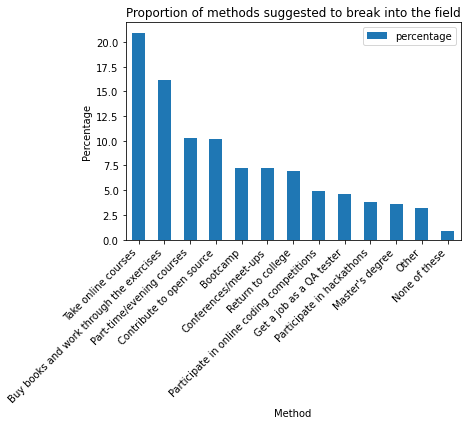

In [72]:
total_counted_df.plot(x = 'method', y = 'percentage', kind = 'bar')
plt.xlabel('Method')
plt.ylabel('Percentage')
plt.title('Proportion of methods suggested to break into the field')
plt.xticks(rotation=45, ha='right')
plt.show()

Answer: Online courses and books are the clear favourites. Everything after that got mentioned 10% of the time or less. 



**Question 2: Was there any biases in these suggestions?**  
did parent's education level influence the suggestion made by those surveyed?

In [74]:
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS app,At leas

In [77]:
missing_vals_count_par_ed = df['HighestEducationParents'].isnull().sum()
missing_vals_count_par_ed

16454

Approx 1/3 of the Parent's Education column is missing values. Similar to question 1, I believe we can drop these as this si the only column we are focusing on here and interpolating wouldn't make sense.

In [78]:
clean_df = df.dropna(subset = ['HighestEducationParents'])

In [81]:
get_unique_vals(clean_df, 'HighestEducationParents', '; ')


['A professional degree',
 'Primary/elementary school',
 "Some college/university study, no bachelor's degree",
 "A master's degree",
 'High school',
 'A doctoral degree',
 "A bachelor's degree",
 "I don't know/not sure",
 'No education',
 'I prefer not to answer']

We now need to split these into two ategories - 1: masters, PhD, professional 2: bachelors and below. 
We can then compare how those cohorts suggested one breaks into the field and explore whether parent's education was 
an influence.


In [85]:
def parents_education(par_ed_val):
    '''
        par_ed_val: a value from the 'HighestEducationParents' column
    '''
    
    if par_ed_val in ("A master's degree", 'A doctoral degree', 'A professional degree'):
         return 1
    else:
        return 0

# test output on top 10    
clean_df['HighestEducationParents'].apply(parents_education)[:10]
        

0     0
1     1
2     1
3     1
5     0
6     1
7     1
8     0
9     1
10    0
Name: HighestEducationParents, dtype: int64

In [89]:
# add new 'ParentEd' column as our flag

clean_df['ParentEd'] = clean_df['HighestEducationParents'].apply(parents_education)

# splitting the original df based on this category
parent_ed_1 = clean_df[clean_df['ParentEd'] == 1]
parent_ed_0 = clean_df[clean_df['ParentEd'] == 0]

# sense check
print(parent_ed_1['ParentEd'][:10])
print(parent_ed_1.shape, parent_ed_0.shape)

0     0
5     0
8     0
10    0
12    0
14    0
16    0
21    0
22    0
23    0
Name: ParentEd, dtype: int64
(11167, 155) (23771, 155)


<ipython-input-89-be05acb08cdd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['ParentEd'] = clean_df['HighestEducationParents'].apply(parents_education)


In [90]:
parent_ed_0['CousinEducation'].shape

(23771,)

Now let's use the functions from Q1 to get the counts of suggested method for both groups and then we can compare

In [91]:
# first we need to get the raw counts with the new df's above

raw_count_1 = parent_ed_1['CousinEducation'].value_counts().reset_index()
raw_count_1.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
#print(raw_count_1)

raw_count_0 = parent_ed_0['CousinEducation'].value_counts().reset_index()
raw_count_0.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
#print(cous_ed_vals)

# now use our accumulate_counts function to get the real counts

real_count_1 = accumulate_counts(raw_count_1, 'method', 'count', unique_vals)
real_count_1.set_index('method', inplace=True) # so we can merge dfs easily
perc_real_count_1 = real_count_1/real_count_1.sum()
real_count_0 = accumulate_counts(raw_count_0, 'method', 'count', unique_vals)
real_count_0.set_index('method', inplace=True)
perc_real_count_0 = real_count_0/real_count_0.sum()

#print(real_count_0)

comp_df = pd.merge(perc_real_count_1, perc_real_count_0, left_index=True, right_index=True)
comp_df.columns = ['parent_ed_1', 'parent_ed_0']
comp_df['Diff'] = comp_df['parent_ed_1'] - comp_df['parent_ed_0']
display(comp_df.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d']))


,parent_ed_1,parent_ed_0,Diff
method,,,
Take online courses,0.205850,0.211702,-0.005852
Buy books and work through the exercises,0.160979,0.163590,-0.002611
Contribute to open source,0.106606,0.101528,0.005078
Part-time/evening courses,0.096956,0.105944,-0.008989
Bootcamp,0.075415,0.070848,0.004568
Return to college,0.070292,0.069212,0.001079
Conferences/meet-ups,0.067058,0.074797,-0.007739
Get a job as a QA tester,0.046961,0.046570,0.000391
Participate in online coding competitions,0.046165,0.048182,-0.002018


The biggest difference is in suggestions of master's degrees with just over 1%.
Developers with Parents who are educated with higher education are ~33% more likely to suggest using formal higher educaiton as a means of breaking into the field. 

Let's make a simpler/clearer graph to show results


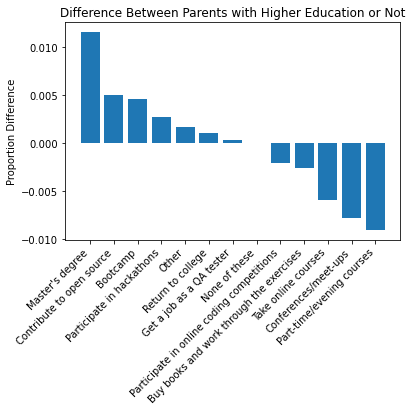

In [92]:
comp_df_sorted = comp_df.sort_values(by='Diff', ascending=False)

plt.bar(comp_df_sorted.index, comp_df_sorted['Diff'])
plt.ylabel('Proportion Difference')
plt.title('Difference Between Parents with Higher Education or Not')
plt.xticks(comp_df_sorted.index, rotation=45, ha='right')
plt.show()

Let's look at potential bias

In [104]:
masters_overall_pop = 3.1755
masters_par_ed_pop = 4.3329

bias_ratio = masters_par_ed_pop/masters_overall_pop

bias_ratio
# gives us 1.1952


1.3644780349551253

Answer: when comparing the two populations, 'master's degree' does give us the bggest difference in occurrence 
which is interesting. However the difference is not that big ~ 1%.

**Question 3: exploring the most popular languages/tools that those in the profession have.**  
i.e. potentially the most valuable to learn for those looking to enter the field  

1 - filter df by those who are professional coders, 2 - explore relvant columns about languages and tools

In [17]:
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary,ParentEd
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS ap

In [20]:
condition = schema_df.Column == 'Professional'
q_desc = schema_df.loc[condition, 'Question'].iloc[0]

print(q_desc)

Which of the following best describes you?


In [21]:
prof_unique_vals = df['Professional'].value_counts().reset_index()
prof_unique_vals

,index,Professional
0,Professional developer,36131
1,Student,8224
2,Professional non-developer who sometimes write...,5140
3,Used to be a professional developer,983
4,None of these,914


In [22]:
employment_unique_vals = df['EmploymentStatus'].value_counts().reset_index()
employment_unique_vals

,index,EmploymentStatus
0,Employed full-time,36148
1,"Independent contractor, freelancer, or self-em...",5233
2,Employed part-time,3180
3,"Not employed, and not looking for work",2791
4,"Not employed, but looking for work",2786
5,I prefer not to say,1086
6,Retired,168


As our working dataframe, I'm going to filter the original df by those who are a) professional programmers and b) currently employed. This is because the perspective of this analysis is gaining insight for those who want to enter the industry currently.

In [23]:
q3_df = df[(df['EmploymentStatus'] == 'Employed full-time') & (df['Professional'] == 'Professional developer')]

q3_df.shape

(30211, 155)

In [94]:
missing_vals_count_q3 = q3_df['HaveWorkedLanguage'].isnull().sum()
missing_vals_count_q3

7285

Approx 1/4 of the languages column in our working df are missing values. Similar to the previous questions I believe we can drop them here.

In [95]:
clean_q3_df = q3_df.dropna(subset = ['HaveWorkedLanguage'])

We have our working dataframe now, let's explore the columns about languages used. 

In [99]:
lang_val_counts_messy = clean_q3_df['HaveWorkedLanguage'].value_counts().reset_index()
lang_val_counts_messy.rename(columns={'index': 'language', 'HaveWorkedLanguage': 'count'}, inplace=True)
lang_val_counts_messy

,language,count
0,C#; JavaScript; SQL,1104
1,JavaScript; PHP; SQL,790
2,Java,623
3,Java; JavaScript; SQL,532
4,JavaScript,527
...,...,...
5409,C; Groovy; Python,1
5410,CoffeeScript; JavaScript; PHP; Python; Ruby; S...,1
5411,Assembly; JavaScript; Perl; PHP; SQL,1
5412,JavaScript; Perl; PHP; Python; Ruby; SQL; Type...,1


Looks like a job for .... get_unique_vals and accumulate_counts!!!!!

In [100]:
lang_unique_vals = get_unique_vals(clean_q3_df, 'HaveWorkedLanguage', '; ')
lang_unique_vals

['C',
 'C#',
 'Dart',
 'Haskell',
 'Smalltalk',
 'Objective-C',
 'Assembly',
 'TypeScript',
 'Go',
 'Perl',
 'JavaScript',
 'Ruby',
 'Clojure',
 'Groovy',
 'Hack',
 'F#',
 'Lua',
 'Java',
 'PHP',
 'CoffeeScript',
 'C++',
 'Matlab',
 'Rust',
 'Scala',
 'Visual Basic 6',
 'Elixir',
 'R',
 'Common Lisp',
 'VB.NET',
 'SQL',
 'Python',
 'Julia',
 'VBA',
 'Swift',
 'Erlang']

In [101]:
lang_val_counts = accumulate_counts(lang_val_counts_messy, 'language', 'count', lang_unique_vals)
lang_val_counts

,language,count
17,Java,18224
10,JavaScript,15226
0,C,13201
29,SQL,12336
1,C#,8628
30,Python,6235
18,PHP,5821
20,C++,4236
26,R,2856
7,TypeScript,2561


In [102]:
lang_val_counts['percentage'] = (lang_val_counts['count']/lang_val_counts['count'].sum()) * 100

lang_val_counts

,language,count,percentage
17,Java,18224,17.242228
10,JavaScript,15226,14.405737
0,C,13201,12.489829
29,SQL,12336,11.671429
1,C#,8628,8.163188
30,Python,6235,5.899105
18,PHP,5821,5.507408
20,C++,4236,4.007796
26,R,2856,2.702140
7,TypeScript,2561,2.423033


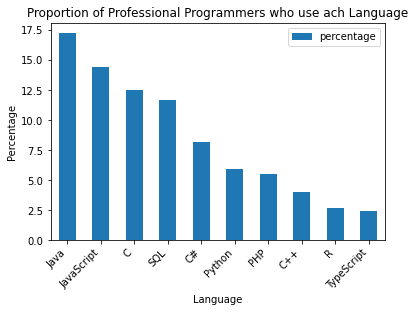

In [103]:
lang_val_counts[:10].plot(x = 'language', y = 'percentage', kind = 'bar')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.title('Proportion of Professional Programmers who use ach Language')
plt.xticks(rotation=45, ha='right')
plt.show()

Maybe let's do a cutoff and get rid of those below 2 % to make this a bit clearer. The top ones are the focus after all

Answer: Java is the most common, while javascript, C and SQL are all used by at least 10% of the current professional programmers surveyed. 

# Evaluation  

Q1: We saw that online courses and books were the top suggestions for methods to enter the field  
Q2: It looks like there was potentially some small amount of bias here as we saw that those with higher educated parents were ~33% more likely to suggest a master's degree  
Q3: Java is the most common programming language used by this population, with javascript, C and SQL are still right up there.  
